### Protein Family Classification

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
family_classification_metadata = pd.read_table('../seminar_5/data/family_classification_metadata.tab')
family_classification_sequences = pd.read_table('../seminar_5/data/family_classification_sequences.tab')

In [3]:
family_classification_metadata.head()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
0,Q6GZX4,001R_FRG3G,Putative transcription factor 001R,Pox_VLTF3,Poxvirus Late Transcription Factor VLTF3 like
1,Q6GZX3,002L_FRG3G,Uncharacterized protein 002L,DUF230,Poxvirus proteins of unknown function
2,Q6GZX0,005R_FRG3G,Uncharacterized protein 005R,US22,US22 like
3,Q91G88,006L_IIV6,Putative KilA-N domain-containing protein 006L,DUF3627,Protein of unknown function (DUF3627)
4,Q197F3,007R_IIV3,Uncharacterized protein 007R,DUF2738,Protein of unknown function (DUF2738)


In [4]:
family_classification_sequences.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [5]:
family_classification_metadata.describe()

,SwissProtAccessionID,LongID,ProteinName,FamilyID,FamilyDescription
count,324018,324018,324018,324018,324018
unique,287308,295671,56951,7027,6967
top,Q1X881,POLG_YEFVA,UvrABC system protein B,MMR_HSR1,50S ribosome-binding GTPase
freq,16,12,1500,3084,3084


#### Task:
    
Use your ProtVec embedding from homework 5 to perform protein family classification using RNN.

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

* use 1000 most frequent families for classification
* validate your results on the train-test split
* reduce the dimensionality of the protein-space using Stochastic Neighbor Embedding and visualize two most frequent classes
* compare your RNN results with SVM
* visualization and metrics are up to you

In [6]:
NUMBER_OF_FAMILIES = 500
MAX_PROTEIN_LENGTH = 500
def get_families(size=NUMBER_OF_FAMILIES):
    counter = {}
    for id in family_classification_metadata["FamilyID"]:
        if id not in counter:
            counter[id] = 0
        counter[id] += 1
    
    sorted_families = sorted(counter, key=counter.__getitem__, reverse=True)
    return sorted_families[:size]
            

In [7]:
families = get_families()
families_map = {fam: i for i, fam in enumerate(families)}

In [8]:
def process_prot2vec_from_article():
    res_dict = {}
    for line in pd.read_csv('../seminar_6/data/protVec_100d_3grams.csv').as_matrix():
        split_line = line[0].split()
        res_dict[split_line[0]] = np.array([float(x) for x in split_line[1:]])
    return res_dict

In [9]:
prot2vec = process_prot2vec_from_article()

In [10]:
from lazy import lazy

class SequenceClassificationModel:
    def __init__(self, params):
        self.params = params
        self._create_placeholders()
        self.prediction
        self.cost
        self.error
        self.optimize
        self._create_summaries()
    
    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.data = tf.placeholder(tf.float32, [None, self.params.seq_length, self.params.embed_length])
            self.target = tf.placeholder(tf.float32, [None, NUMBER_OF_FAMILIES])
  
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar('loss', self.cost)
            tf.summary.scalar('erroe', self.error)
            self.summary = tf.summary.merge_all()
            saver = tf.train.Saver()
            
    @lazy
    def length(self):
    # First, we obtain the lengths of sequences in the current data batch. We need this since
    # the data comes as a single tensor, padded with zero vectors to the longest review length.
    # Instead of keeping track of the sequence lengths of every review, we just compute it
    # dynamically in TensorFlow.
    
        with tf.name_scope("seq_length"):
            used = tf.sign(tf.reduce_max(tf.abs(self.data), reduction_indices=2))
            length = tf.reduce_sum(used, reduction_indices=1)
            length = tf.cast(length, tf.int32)
        return length
    
    @lazy
    def prediction(self):
    # Note that the last relevant output activation of the RNN has a different index for each
    # sequence in the training batch. This is because each review has a different length. We
    # already know the length of each sequence.
    # The problem is that we want to index in the dimension of time steps, which is
    # the second dimension in the batch of shape  (sequences, time_steps, word_vectors) .
    
        with tf.name_scope("recurrent_layer"):
            output, _ = tf.nn.dynamic_rnn(
                self.params.rnn_cell(self.params.rnn_hidden),
                self.data,
                dtype=tf.float32,
                sequence_length=self.length
            )
        last = self._last_relevant(output, self.length)

        with tf.name_scope("softmax_layer"):
            num_classes = int(self.target.get_shape()[1])
            weight = tf.Variable(tf.truncated_normal(
                [self.params.rnn_hidden, num_classes], stddev=0.01))
            bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))
            prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)
        return prediction
    
    @lazy
    def cost(self):
        cross_entropy = -tf.reduce_sum(self.target * tf.log(self.prediction))
        return cross_entropy
    
    @lazy
    def error(self):
        self.mistakes = tf.not_equal(
            tf.argmax(self.target, 1), tf.argmax(self.prediction, 1))
        return tf.reduce_mean(tf.cast(self.mistakes, tf.float32))
    
    @lazy
    def optimize(self):
    # RNNs are quite hard to train and weights tend to diverge if the hyper parameters do not
    # play nicely together. The idea of gradient clipping is to restrict the the values of the
    # gradient to a sensible range. This way, we can limit the maximum weight updates.

        with tf.name_scope("optimization"):
            gradient = self.params.optimizer.compute_gradients(self.cost)
            if self.params.gradient_clipping:
                limit = self.params.gradient_clipping
                gradient = [
                    (tf.clip_by_value(g, -limit, limit), v)
                    if g is not None else (None, v)
                    for g, v in gradient]
            optimize = self.params.optimizer.apply_gradients(gradient)
        return optimize
    
    @staticmethod
    def _last_relevant(output, length):
        with tf.name_scope("last_relevant"):
            # As of now, TensorFlow only supports indexing along the first dimension, using
            # tf.gather() . We thus flatten the first two dimensions of the output activations from their
            # shape of  sequences x time_steps x word_vectors  and construct an index into this resulting tensor.
            batch_size = tf.shape(output)[0]
            max_length = int(output.get_shape()[1])
            output_size = int(output.get_shape()[2])

            # The index takes into account the start indices for each sequence in the flat tensor and adds
            # the sequence length to it. Actually, we only add  length - 1  so that we select the last valid
            # time step.
            index = tf.range(0, batch_size) * max_length + (length - 1)
            flat = tf.reshape(output, [-1, output_size])
            relevant = tf.gather(flat, index)
        return relevant

In [11]:
def parse(protein):
    embedded = []
    for i in range(0, len(protein) - 3, 3):
        try:
            embedded.append(prot2vec[protein[i:i+3]])
        except KeyError:
            embedded.append(prot2vec['<unk>'])
    return np.array(embedded)
    
class Embedding:
    def __init__(self, length, parser=parse):
        self.parser = parser
        self._length = length
        self.dimensions = 100
        
    def __call__(self, protein):
        embedded = self.parser(protein)
        if len(embedded) < self._length:
            embedded = np.vstack((embedded, np.zeros(shape=(self._length - embedded.shape[0], self.dimensions))))
        return np.array(embedded)

In [12]:
proteins = np.array(family_classification_sequences['Sequences'])
families = np.array(family_classification_metadata['FamilyID'])

length = MAX_PROTEIN_LENGTH

embedding = Embedding(length)

In [13]:
from attrdict import AttrDict

params = AttrDict(
    rnn_cell=tf.contrib.rnn.GRUCell,
    rnn_hidden=256,
    optimizer=tf.train.AdamOptimizer(0.001),
    batch_size=256,
    gradient_clipping=100,
    seq_length=length,
    embed_length=embedding.dimensions
)

In [14]:
def build_target(family):
    return np.eye(NUMBER_OF_FAMILIES)[families_map[family]]
    
def preprocess_batched(iterator, length, embedding, batch_size):
    while True:
        data = []
        target = []
        for index in range(batch_size):
            try:
                protein, family = next(iterator)
            except:
                return
            data.append(embedding(protein))
            target.append(build_target(family))
        yield np.array(data), np.array(target)

In [15]:
valid_indices = []
for i,f in enumerate(families):
    if f not in families_map or len(proteins[i]) > MAX_PROTEIN_LENGTH:
        continue
    valid_indices.append(i)
valid_indices = np.array(valid_indices)
np.random.shuffle(valid_indices)

train_ratio = 0.9

train_indices = valid_indices[:int(valid_indices.shape[0] * train_ratio)]
test_indices = valid_indices[int(valid_indices.shape[0] * train_ratio):]

print(len(train_indices))
print(len(test_indices))

150615
16735


In [16]:
import random
def train_iterator():
    while True:
        index = random.choice(train_indices)
        yield (proteins[index], families[index])
    
def test_iterator():
    for index in test_indices:
        yield (proteins[index], families[index])


In [17]:
tf.reset_default_graph()

model = SequenceClassificationModel(params)

/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [18]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)

batches = preprocess_batched(train_iterator(), length, embedding, params.batch_size)
iterations = 10000
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    
    sess.run(tf.global_variables_initializer())
    summary_writer = tf.summary.FileWriter('graphs', sess.graph)

    for index, batch in enumerate(batches):
        feed = {model.data: batch[0], model.target: batch[1]}
        error, _, summary_str = sess.run([model.error, model.optimize, model.summary], feed)
        print('{}: {:3.1f}%'.format(index + 1, 100 * error))
        if index % 1 == 0:
            summary_writer.add_summary(summary_str, index)
        if index == iterations:
            break
    
    sum_error = 0.
    counter = 0.
    
    testing = preprocess_batched(test_iterator(), length, embedding, params.batch_size)
    for index, batch in enumerate(testing):
        feed = {model.data: batch[0], model.target: batch[1]}
        error = sess.run(model.error, feed)
        sum_error += error
        counter += 1
        print('Accuracy on testing: {:3.1f}%'.format(100 * (1-sum_error/counter)))

1: 100.0%
2: 100.0%
3: 99.2%
4: 97.7%
5: 98.0%
6: 98.4%
7: 99.6%
8: 96.9%
9: 98.4%
10: 97.3%
11: 95.7%
12: 98.8%
13: 95.7%
14: 98.0%
15: 98.4%
16: 97.3%
17: 97.7%
18: 99.2%
19: 98.0%
20: 98.0%
21: 98.4%
22: 98.0%
23: 98.0%
24: 98.4%
25: 96.5%
26: 98.8%
27: 98.8%
28: 98.8%
29: 97.3%
30: 98.4%
31: 98.8%
32: 98.0%
33: 99.2%
34: 98.8%
35: 96.1%
36: 98.0%
37: 97.3%
38: 99.6%
39: 98.8%
40: 98.8%
41: 97.3%
42: 98.8%
43: 97.7%
44: 98.0%
45: 99.2%
46: 97.7%
47: 98.4%
48: 99.2%
49: 99.6%
50: 97.7%
51: 98.0%
52: 98.4%
53: 95.3%
54: 99.2%
55: 98.0%
56: 96.9%
57: 99.2%
58: 98.4%
59: 96.1%
60: 96.5%
61: 98.0%
62: 98.0%
63: 98.4%
64: 98.4%
65: 98.0%
66: 96.9%
67: 98.8%
68: 98.0%
69: 98.8%
70: 97.3%
71: 96.1%
72: 96.9%
73: 97.7%
74: 97.7%
75: 97.3%
76: 98.8%
77: 97.7%
78: 96.9%
79: 97.7%
80: 96.5%
81: 97.3%
82: 97.3%
83: 98.4%
84: 95.7%
85: 98.8%
86: 96.9%
87: 98.4%
88: 95.3%
89: 96.1%
90: 98.4%
91: 96.5%
92: 98.0%
93: 95.7%
94: 96.5%
95: 98.8%
96: 96.1%
97: 98.0%
98: 97.7%
99: 98.8%
100: 96.5%
101: 9

756: 75.0%
757: 77.3%
758: 77.0%
759: 74.2%
760: 71.5%
761: 77.7%
762: 74.2%
763: 71.5%
764: 71.5%
765: 76.2%
766: 73.8%
767: 74.2%
768: 75.0%
769: 72.3%
770: 71.5%
771: 74.6%
772: 71.9%
773: 70.3%
774: 76.2%
775: 73.0%
776: 73.0%
777: 75.8%
778: 75.0%
779: 77.7%
780: 77.3%
781: 77.0%
782: 69.9%
783: 78.9%
784: 72.3%
785: 75.0%
786: 77.0%
787: 75.0%
788: 73.8%
789: 72.3%
790: 71.5%
791: 77.7%
792: 72.7%
793: 71.5%
794: 64.5%
795: 71.1%
796: 70.3%
797: 77.7%
798: 77.0%
799: 71.9%
800: 69.1%
801: 75.0%
802: 75.8%
803: 73.8%
804: 73.8%
805: 69.9%
806: 72.7%
807: 73.8%
808: 75.4%
809: 78.1%
810: 77.7%
811: 77.3%
812: 75.4%
813: 67.6%
814: 70.7%
815: 76.2%
816: 68.4%
817: 68.8%
818: 69.1%
819: 67.6%
820: 71.9%
821: 75.4%
822: 77.7%
823: 76.2%
824: 64.5%
825: 70.3%
826: 72.7%
827: 68.0%
828: 70.3%
829: 74.6%
830: 69.9%
831: 72.7%
832: 70.3%
833: 75.8%
834: 67.6%
835: 68.4%
836: 69.5%
837: 74.6%
838: 74.2%
839: 73.0%
840: 67.6%
841: 74.6%
842: 68.8%
843: 76.6%
844: 72.3%
845: 67.2%
846: 71.9%

1460: 54.3%
1461: 52.7%
1462: 55.1%
1463: 52.7%
1464: 58.6%
1465: 48.4%
1466: 55.9%
1467: 56.2%
1468: 50.0%
1469: 53.1%
1470: 59.0%
1471: 53.9%
1472: 54.7%
1473: 48.4%
1474: 50.4%
1475: 58.2%
1476: 54.3%
1477: 52.3%
1478: 49.2%
1479: 55.1%
1480: 49.2%
1481: 55.9%
1482: 49.6%
1483: 57.0%
1484: 53.1%
1485: 48.0%
1486: 53.5%
1487: 55.1%
1488: 52.0%
1489: 50.4%
1490: 55.1%
1491: 52.0%
1492: 53.9%
1493: 50.8%
1494: 50.8%
1495: 54.7%
1496: 52.3%
1497: 54.7%
1498: 51.2%
1499: 55.9%
1500: 62.5%
1501: 53.5%
1502: 56.2%
1503: 49.6%
1504: 55.5%
1505: 58.6%
1506: 55.1%
1507: 58.6%
1508: 53.1%
1509: 58.6%
1510: 53.5%
1511: 53.1%
1512: 49.6%
1513: 58.6%
1514: 52.3%
1515: 49.6%
1516: 57.8%
1517: 52.3%
1518: 49.6%
1519: 55.1%
1520: 53.1%
1521: 50.0%
1522: 52.7%
1523: 53.1%
1524: 52.0%
1525: 52.3%
1526: 55.5%
1527: 56.2%
1528: 53.1%
1529: 52.7%
1530: 53.5%
1531: 59.0%
1532: 57.4%
1533: 52.0%
1534: 56.2%
1535: 50.4%
1536: 55.1%
1537: 51.6%
1538: 54.7%
1539: 53.5%
1540: 48.8%
1541: 48.0%
1542: 52.3%
1543

2143: 39.5%
2144: 40.6%
2145: 41.8%
2146: 36.3%
2147: 34.4%
2148: 35.9%
2149: 40.2%
2150: 36.3%
2151: 35.9%
2152: 37.5%
2153: 40.2%
2154: 34.4%
2155: 39.5%
2156: 37.9%
2157: 43.0%
2158: 41.0%
2159: 38.7%
2160: 44.1%
2161: 30.5%
2162: 35.9%
2163: 35.5%
2164: 37.5%
2165: 41.0%
2166: 32.0%
2167: 42.2%
2168: 34.4%
2169: 38.3%
2170: 38.3%
2171: 32.0%
2172: 41.0%
2173: 33.2%
2174: 34.4%
2175: 37.9%
2176: 29.7%
2177: 35.9%
2178: 37.5%
2179: 35.5%
2180: 41.0%
2181: 32.0%
2182: 34.4%
2183: 35.5%
2184: 36.7%
2185: 35.9%
2186: 38.3%
2187: 32.0%
2188: 40.2%
2189: 37.1%
2190: 37.1%
2191: 44.1%
2192: 36.7%
2193: 37.5%
2194: 35.2%
2195: 37.1%
2196: 38.7%
2197: 40.6%
2198: 34.0%
2199: 34.4%
2200: 41.0%
2201: 32.8%
2202: 34.4%
2203: 34.8%
2204: 34.0%
2205: 37.5%
2206: 36.3%
2207: 38.7%
2208: 36.3%
2209: 38.7%
2210: 34.4%
2211: 39.8%
2212: 37.5%
2213: 34.0%
2214: 42.2%
2215: 38.3%
2216: 39.5%
2217: 34.0%
2218: 39.8%
2219: 32.8%
2220: 37.5%
2221: 43.8%
2222: 34.0%
2223: 41.8%
2224: 35.9%
2225: 39.5%
2226

2826: 28.1%
2827: 32.4%
2828: 25.8%
2829: 27.7%
2830: 27.0%
2831: 25.8%
2832: 28.9%
2833: 28.1%
2834: 27.0%
2835: 30.9%
2836: 28.5%
2837: 31.2%
2838: 27.0%
2839: 29.7%
2840: 28.1%
2841: 25.8%
2842: 28.5%
2843: 25.0%
2844: 22.7%
2845: 31.6%
2846: 25.0%
2847: 29.7%
2848: 29.3%
2849: 27.7%
2850: 28.9%
2851: 30.5%
2852: 25.4%
2853: 26.2%
2854: 25.4%
2855: 30.9%
2856: 30.5%
2857: 26.2%
2858: 28.9%
2859: 28.9%
2860: 31.6%
2861: 27.3%
2862: 25.0%
2863: 27.7%
2864: 27.7%
2865: 25.0%
2866: 27.7%
2867: 25.8%
2868: 24.2%
2869: 22.7%
2870: 27.7%
2871: 24.6%
2872: 28.5%
2873: 31.2%
2874: 28.9%
2875: 30.1%
2876: 23.8%
2877: 30.5%
2878: 26.2%
2879: 26.6%
2880: 27.3%
2881: 28.5%
2882: 25.8%
2883: 26.2%
2884: 29.7%
2885: 29.3%
2886: 32.0%
2887: 27.3%
2888: 30.1%
2889: 26.6%
2890: 32.0%
2891: 30.9%
2892: 27.3%
2893: 28.1%
2894: 29.3%
2895: 28.1%
2896: 29.3%
2897: 25.4%
2898: 28.9%
2899: 27.7%
2900: 23.0%
2901: 28.5%
2902: 21.5%
2903: 25.4%
2904: 27.7%
2905: 27.3%
2906: 29.7%
2907: 31.2%
2908: 25.0%
2909

3509: 21.9%
3510: 20.7%
3511: 23.4%
3512: 22.3%
3513: 23.8%
3514: 18.8%
3515: 23.4%
3516: 21.5%
3517: 23.8%
3518: 23.4%
3519: 22.3%
3520: 25.8%
3521: 19.1%
3522: 25.8%
3523: 23.0%
3524: 24.2%
3525: 25.4%
3526: 20.3%
3527: 24.2%
3528: 27.7%
3529: 23.8%
3530: 21.5%
3531: 19.5%
3532: 23.8%
3533: 25.0%
3534: 26.2%
3535: 23.0%
3536: 19.9%
3537: 17.2%
3538: 23.8%
3539: 19.1%
3540: 22.3%
3541: 19.1%
3542: 22.3%
3543: 18.8%
3544: 20.3%
3545: 18.4%
3546: 25.8%
3547: 19.1%
3548: 18.4%
3549: 23.0%
3550: 21.9%
3551: 23.0%
3552: 21.1%
3553: 27.0%
3554: 19.1%
3555: 24.6%
3556: 20.3%
3557: 21.1%
3558: 23.0%
3559: 20.7%
3560: 16.8%
3561: 22.3%
3562: 21.1%
3563: 21.5%
3564: 16.0%
3565: 18.0%
3566: 17.6%
3567: 20.7%
3568: 16.4%
3569: 20.7%
3570: 18.8%
3571: 18.4%
3572: 20.3%
3573: 20.7%
3574: 20.7%
3575: 24.2%
3576: 21.9%
3577: 22.7%
3578: 20.7%
3579: 15.2%
3580: 18.0%
3581: 18.8%
3582: 17.2%
3583: 23.0%
3584: 19.1%
3585: 23.8%
3586: 17.6%
3587: 22.3%
3588: 21.5%
3589: 19.5%
3590: 24.6%
3591: 18.4%
3592

4192: 18.0%
4193: 16.0%
4194: 18.8%
4195: 17.6%
4196: 19.5%
4197: 18.8%
4198: 18.8%
4199: 18.4%
4200: 18.4%
4201: 18.4%
4202: 19.9%
4203: 19.1%
4204: 21.5%
4205: 21.1%
4206: 14.1%
4207: 18.8%
4208: 19.1%
4209: 18.0%
4210: 18.0%
4211: 19.5%
4212: 19.5%
4213: 17.6%
4214: 15.2%
4215: 18.8%
4216: 20.3%
4217: 17.6%
4218: 18.0%
4219: 19.1%
4220: 18.0%
4221: 19.9%
4222: 18.4%
4223: 18.0%
4224: 19.1%
4225: 17.2%
4226: 17.6%
4227: 18.4%
4228: 18.4%
4229: 16.4%
4230: 19.1%
4231: 17.6%
4232: 12.1%
4233: 21.1%
4234: 17.6%
4235: 16.0%
4236: 19.1%
4237: 19.5%
4238: 20.3%
4239: 23.4%
4240: 17.2%
4241: 21.1%
4242: 21.5%
4243: 20.3%
4244: 12.5%
4245: 18.0%
4246: 20.3%
4247: 15.2%
4248: 23.8%
4249: 17.6%
4250: 21.9%
4251: 15.6%
4252: 19.9%
4253: 27.3%
4254: 19.9%
4255: 14.5%
4256: 19.9%
4257: 16.0%
4258: 18.0%
4259: 19.1%
4260: 19.9%
4261: 20.3%
4262: 19.5%
4263: 18.4%
4264: 18.0%
4265: 16.8%
4266: 13.7%
4267: 16.8%
4268: 17.2%
4269: 21.5%
4270: 16.8%
4271: 17.2%
4272: 17.6%
4273: 20.7%
4274: 18.4%
4275

4875: 21.1%
4876: 20.7%
4877: 15.6%
4878: 19.1%
4879: 15.2%
4880: 16.4%
4881: 19.5%
4882: 18.0%
4883: 16.8%
4884: 13.3%
4885: 16.8%
4886: 15.6%
4887: 12.5%
4888: 18.4%
4889: 13.7%
4890: 14.5%
4891: 14.5%
4892: 16.0%
4893: 17.6%
4894: 14.1%
4895: 14.8%
4896: 11.7%
4897: 18.0%
4898: 14.1%
4899: 14.1%
4900: 18.0%
4901: 13.7%
4902: 16.8%
4903: 14.5%
4904: 15.2%
4905: 16.0%
4906: 19.5%
4907: 15.6%
4908: 15.2%
4909: 18.0%
4910: 14.1%
4911: 19.9%
4912: 10.9%
4913: 20.7%
4914: 14.5%
4915: 14.1%
4916: 17.2%
4917: 15.2%
4918: 14.8%
4919: 16.8%
4920: 16.8%
4921: 14.5%
4922: 16.0%
4923: 13.3%
4924: 14.8%
4925: 16.4%
4926: 14.1%
4927: 17.2%
4928: 20.7%
4929: 11.7%
4930: 14.1%
4931: 16.4%
4932: 14.5%
4933: 12.9%
4934: 16.0%
4935: 15.2%
4936: 15.6%
4937: 12.9%
4938: 12.5%
4939: 16.4%
4940: 16.4%
4941: 18.4%
4942: 21.1%
4943: 14.5%
4944: 17.2%
4945: 15.2%
4946: 13.7%
4947: 13.7%
4948: 13.3%
4949: 14.8%
4950: 21.1%
4951: 16.0%
4952: 14.1%
4953: 16.0%
4954: 12.9%
4955: 14.8%
4956: 13.7%
4957: 13.3%
4958

5559: 9.4%
5560: 11.7%
5561: 11.3%
5562: 17.6%
5563: 15.6%
5564: 14.8%
5565: 15.6%
5566: 14.1%
5567: 10.9%
5568: 10.9%
5569: 18.8%
5570: 13.3%
5571: 16.4%
5572: 15.6%
5573: 17.6%
5574: 14.5%
5575: 12.9%
5576: 14.5%
5577: 12.5%
5578: 17.2%
5579: 14.1%
5580: 12.5%
5581: 15.2%
5582: 16.4%
5583: 11.3%
5584: 15.2%
5585: 10.9%
5586: 12.1%
5587: 10.9%
5588: 10.5%
5589: 13.7%
5590: 12.1%
5591: 13.7%
5592: 16.4%
5593: 14.8%
5594: 13.7%
5595: 18.0%
5596: 15.2%
5597: 14.1%
5598: 14.5%
5599: 14.1%
5600: 12.9%
5601: 15.6%
5602: 12.5%
5603: 9.8%
5604: 13.3%
5605: 13.3%
5606: 13.7%
5607: 12.5%
5608: 16.8%
5609: 11.7%
5610: 10.5%
5611: 14.1%
5612: 12.9%
5613: 10.2%
5614: 10.9%
5615: 10.5%
5616: 16.8%
5617: 9.4%
5618: 16.4%
5619: 16.0%
5620: 18.8%
5621: 12.9%
5622: 10.9%
5623: 12.5%
5624: 12.1%
5625: 13.7%
5626: 15.6%
5627: 13.3%
5628: 14.1%
5629: 12.9%
5630: 12.5%
5631: 15.6%
5632: 14.8%
5633: 11.3%
5634: 16.0%
5635: 14.8%
5636: 15.6%
5637: 15.2%
5638: 14.5%
5639: 9.8%
5640: 16.0%
5641: 9.0%
5642: 12.

6245: 12.1%
6246: 11.7%
6247: 13.7%
6248: 10.5%
6249: 15.6%
6250: 11.3%
6251: 12.1%
6252: 10.5%
6253: 11.3%
6254: 12.9%
6255: 14.5%
6256: 9.4%
6257: 17.2%
6258: 12.1%
6259: 9.4%
6260: 14.5%
6261: 10.5%
6262: 13.3%
6263: 12.5%
6264: 11.3%
6265: 13.7%
6266: 10.2%
6267: 13.3%
6268: 14.1%
6269: 13.3%
6270: 13.3%
6271: 11.3%
6272: 11.7%
6273: 10.9%
6274: 9.8%
6275: 8.6%
6276: 15.2%
6277: 12.5%
6278: 11.3%
6279: 10.9%
6280: 11.3%
6281: 12.1%
6282: 8.2%
6283: 9.4%
6284: 12.5%
6285: 14.8%
6286: 12.5%
6287: 15.2%
6288: 12.9%
6289: 14.8%
6290: 11.3%
6291: 11.3%
6292: 15.2%
6293: 11.3%
6294: 9.0%
6295: 14.1%
6296: 12.5%
6297: 9.4%
6298: 11.3%
6299: 12.5%
6300: 14.1%
6301: 9.0%
6302: 11.7%
6303: 14.8%
6304: 14.5%
6305: 12.5%
6306: 10.5%
6307: 13.3%
6308: 14.1%
6309: 14.8%
6310: 13.3%
6311: 13.3%
6312: 13.3%
6313: 16.8%
6314: 15.2%
6315: 14.1%
6316: 14.5%
6317: 12.5%
6318: 13.3%
6319: 13.3%
6320: 15.2%
6321: 12.5%
6322: 14.1%
6323: 14.5%
6324: 16.0%
6325: 10.2%
6326: 12.9%
6327: 12.9%
6328: 12.1%
6

6936: 12.9%
6937: 12.5%
6938: 13.3%
6939: 12.5%
6940: 12.5%
6941: 11.3%
6942: 14.5%
6943: 18.4%
6944: 11.7%
6945: 9.4%
6946: 13.3%
6947: 10.2%
6948: 15.2%
6949: 10.2%
6950: 8.6%
6951: 10.9%
6952: 9.4%
6953: 11.7%
6954: 11.3%
6955: 11.3%
6956: 11.3%
6957: 9.8%
6958: 12.1%
6959: 16.4%
6960: 7.8%
6961: 12.1%
6962: 11.7%
6963: 13.7%
6964: 11.7%
6965: 11.3%
6966: 14.5%
6967: 16.4%
6968: 12.5%
6969: 11.3%
6970: 9.4%
6971: 15.6%
6972: 12.1%
6973: 8.2%
6974: 10.5%
6975: 10.9%
6976: 13.3%
6977: 12.5%
6978: 14.1%
6979: 11.3%
6980: 10.9%
6981: 14.5%
6982: 12.9%
6983: 13.7%
6984: 13.7%
6985: 14.1%
6986: 14.1%
6987: 15.6%
6988: 11.3%
6989: 7.4%
6990: 10.9%
6991: 11.7%
6992: 9.0%
6993: 12.5%
6994: 10.9%
6995: 10.9%
6996: 12.9%
6997: 12.5%
6998: 12.5%
6999: 12.9%
7000: 14.1%
7001: 10.5%
7002: 10.5%
7003: 9.8%
7004: 10.9%
7005: 11.7%
7006: 9.4%
7007: 11.7%
7008: 10.5%
7009: 12.5%
7010: 14.1%
7011: 12.5%
7012: 12.9%
7013: 12.9%
7014: 12.9%
7015: 11.7%
7016: 13.7%
7017: 11.3%
7018: 12.9%
7019: 14.5%
702

7631: 12.1%
7632: 8.2%
7633: 9.8%
7634: 10.2%
7635: 10.9%
7636: 9.4%
7637: 10.2%
7638: 12.1%
7639: 10.5%
7640: 13.3%
7641: 10.5%
7642: 8.6%
7643: 12.5%
7644: 11.3%
7645: 11.7%
7646: 9.4%
7647: 9.0%
7648: 10.9%
7649: 10.9%
7650: 9.0%
7651: 10.9%
7652: 12.9%
7653: 9.0%
7654: 12.5%
7655: 11.3%
7656: 11.3%
7657: 9.8%
7658: 12.1%
7659: 10.5%
7660: 10.2%
7661: 9.4%
7662: 12.9%
7663: 11.3%
7664: 13.7%
7665: 11.3%
7666: 15.2%
7667: 12.5%
7668: 8.2%
7669: 9.4%
7670: 12.1%
7671: 11.3%
7672: 11.7%
7673: 9.8%
7674: 7.8%
7675: 11.3%
7676: 10.9%
7677: 12.9%
7678: 12.1%
7679: 13.7%
7680: 8.2%
7681: 11.3%
7682: 11.3%
7683: 7.0%
7684: 8.6%
7685: 15.2%
7686: 9.8%
7687: 12.9%
7688: 9.0%
7689: 10.9%
7690: 8.6%
7691: 14.8%
7692: 10.2%
7693: 8.6%
7694: 10.2%
7695: 11.7%
7696: 11.3%
7697: 11.3%
7698: 8.2%
7699: 7.4%
7700: 10.9%
7701: 11.7%
7702: 11.7%
7703: 9.0%
7704: 13.3%
7705: 7.8%
7706: 12.9%
7707: 11.3%
7708: 13.7%
7709: 10.5%
7710: 12.1%
7711: 10.9%
7712: 8.6%
7713: 12.5%
7714: 10.5%
7715: 9.0%
7716: 1

8327: 10.9%
8328: 9.8%
8329: 12.9%
8330: 9.0%
8331: 12.5%
8332: 8.6%
8333: 12.9%
8334: 14.5%
8335: 10.2%
8336: 10.9%
8337: 10.5%
8338: 11.7%
8339: 11.7%
8340: 12.1%
8341: 12.1%
8342: 9.0%
8343: 7.4%
8344: 10.2%
8345: 9.8%
8346: 12.5%
8347: 9.4%
8348: 15.2%
8349: 11.3%
8350: 9.8%
8351: 9.4%
8352: 14.8%
8353: 10.2%
8354: 15.2%
8355: 12.1%
8356: 10.5%
8357: 10.9%
8358: 9.4%
8359: 7.0%
8360: 10.2%
8361: 12.9%
8362: 12.1%
8363: 10.9%
8364: 12.9%
8365: 7.0%
8366: 14.8%
8367: 9.8%
8368: 12.5%
8369: 10.5%
8370: 9.0%
8371: 12.1%
8372: 11.3%
8373: 10.2%
8374: 11.3%
8375: 9.8%
8376: 12.1%
8377: 10.9%
8378: 9.4%
8379: 12.5%
8380: 12.1%
8381: 14.5%
8382: 11.3%
8383: 14.1%
8384: 8.2%
8385: 9.8%
8386: 9.0%
8387: 10.5%
8388: 9.0%
8389: 9.8%
8390: 12.9%
8391: 11.3%
8392: 7.4%
8393: 11.3%
8394: 5.9%
8395: 11.3%
8396: 12.9%
8397: 11.7%
8398: 11.7%
8399: 12.9%
8400: 14.8%
8401: 10.9%
8402: 12.1%
8403: 9.0%
8404: 11.3%
8405: 8.2%
8406: 15.2%
8407: 11.7%
8408: 9.8%
8409: 10.9%
8410: 7.0%
8411: 11.7%
8412: 1

9035: 14.1%
9036: 11.7%
9037: 11.7%
9038: 12.5%
9039: 11.3%
9040: 12.5%
9041: 10.5%
9042: 10.9%
9043: 10.9%
9044: 14.1%
9045: 11.3%
9046: 10.2%
9047: 9.4%
9048: 9.8%
9049: 10.9%
9050: 13.3%
9051: 11.7%
9052: 12.1%
9053: 13.7%
9054: 8.6%
9055: 9.4%
9056: 10.9%
9057: 9.4%
9058: 8.6%
9059: 10.5%
9060: 10.2%
9061: 9.4%
9062: 9.4%
9063: 10.9%
9064: 13.3%
9065: 13.7%
9066: 17.2%
9067: 11.7%
9068: 12.5%
9069: 7.8%
9070: 10.5%
9071: 11.7%
9072: 12.5%
9073: 11.3%
9074: 10.9%
9075: 9.8%
9076: 10.9%
9077: 12.5%
9078: 10.2%
9079: 8.2%
9080: 10.5%
9081: 7.8%
9082: 10.9%
9083: 10.2%
9084: 10.5%
9085: 12.1%
9086: 10.9%
9087: 12.9%
9088: 9.8%
9089: 9.0%
9090: 11.7%
9091: 8.2%
9092: 9.0%
9093: 9.4%
9094: 10.9%
9095: 10.5%
9096: 9.4%
9097: 9.4%
9098: 11.7%
9099: 12.5%
9100: 10.2%
9101: 12.5%
9102: 12.9%
9103: 12.5%
9104: 12.9%
9105: 14.8%
9106: 10.2%
9107: 11.7%
9108: 10.2%
9109: 12.1%
9110: 12.1%
9111: 12.9%
9112: 13.3%
9113: 7.8%
9114: 11.7%
9115: 15.2%
9116: 11.3%
9117: 11.3%
9118: 8.6%
9119: 12.9%
9

9748: 7.4%
9749: 10.2%
9750: 8.2%
9751: 7.0%
9752: 8.6%
9753: 9.8%
9754: 12.1%
9755: 10.2%
9756: 9.8%
9757: 6.6%
9758: 9.8%
9759: 12.5%
9760: 12.5%
9761: 9.0%
9762: 10.2%
9763: 7.4%
9764: 13.3%
9765: 9.4%
9766: 5.1%
9767: 10.5%
9768: 8.2%
9769: 8.6%
9770: 6.2%
9771: 15.2%
9772: 12.1%
9773: 12.1%
9774: 7.4%
9775: 8.6%
9776: 9.4%
9777: 9.0%
9778: 7.8%
9779: 9.8%
9780: 9.8%
9781: 10.5%
9782: 9.4%
9783: 9.8%
9784: 9.8%
9785: 8.6%
9786: 9.0%
9787: 9.4%
9788: 7.8%
9789: 7.4%
9790: 6.6%
9791: 10.2%
9792: 13.7%
9793: 9.8%
9794: 9.4%
9795: 6.6%
9796: 12.5%
9797: 10.9%
9798: 10.2%
9799: 9.4%
9800: 10.2%
9801: 13.7%
9802: 10.5%
9803: 5.1%
9804: 13.3%
9805: 11.3%
9806: 8.6%
9807: 10.2%
9808: 9.0%
9809: 10.2%
9810: 10.9%
9811: 9.8%
9812: 9.8%
9813: 10.2%
9814: 7.4%
9815: 10.5%
9816: 10.2%
9817: 9.4%
9818: 10.9%
9819: 10.2%
9820: 12.5%
9821: 10.5%
9822: 9.8%
9823: 9.8%
9824: 12.1%
9825: 9.4%
9826: 9.8%
9827: 10.2%
9828: 8.2%
9829: 8.2%
9830: 9.8%
9831: 5.9%
9832: 9.4%
9833: 10.2%
9834: 10.9%
9835: 1

In [19]:
print('Accuracy on testing: {:3.1f}%'.format(100 * (1-sum_error/counter)))

Accuracy on testing: 87.1%


In [85]:
def get_proteins_sk(indices, length, prot2vec):
    def sk_parse(protein):
        embedded = []
        for i in range(0, len(protein) - 3, 3):
            try:
                embedded.append(prot2vec[protein[i:i+3]])
            except KeyError:
                embedded.append(prot2vec['<unk>'])
        res_embedded = embedded[0]
        for i in range(1, len(embedded)):
            res_embedded += embedded[i]
        #res_embedded = np.array(res_embedded)
        res_embedded /= len(res_embedded)
        return np.array(res_embedded)
    data = []
    for index in indices:
        data.append(sk_parse(proteins[index]))
    return np.array(data)

def get_families_sk(indices, length):
    target = []
    for index in indices:
        target.append(families_map[families[index]])
    return np.array(target)

In [26]:
sk_train_prot = get_proteins_sk(train_indices, length, prot2vec)
sk_train_fams = get_families_sk(train_indices, length, prot2vec)

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
RF = RandomForestClassifier(n_estimators=16, max_depth=16)
RF.fit(sk_train_prot, sk_train_fams)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=16, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [29]:
sk_test_prot = get_proteins_sk(test_indices, length, prot2vec)
sk_test_fams = get_families_sk(test_indices, length, prot2vec)

In [34]:
print('Accuracy on testing for RandomForest: {:3.4f}%'.format(100 * RF.score(sk_test_prot, sk_test_fams)))

Accuracy on testing for RandomForest: 51.5984%


In [82]:
from sklearn.manifold import TSNE

In [83]:
embeddings = []
for trigram in prot2vec:
    embeddings.append(prot2vec[trigram])
embeddings = np.array(embeddings)

tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

In [97]:
new_prot2vec = {}
for i, trigram in enumerate(prot2vec):
    new_prot2vec[trigram] = embeddings_tsne[i]
print(embeddings_tsne.shape)

(9047, 2)


In [106]:
valid_proteins = get_proteins_sk(valid_indices, length, new_prot2vec)
valid_families = get_families_sk(valid_indices, length)

In [107]:
first_inds = np.where(valid_families == 0)[0]
second_inds = np.where(valid_families == 1)[0]
third_inds = np.where(valid_families == 2)[0]

In [112]:
most_common_prots = np.vstack((valid_proteins[first_inds], valid_proteins[second_inds]))
most_common_fams = np.hstack((np.zeros_like(first_inds), np.ones_like(second_inds))).reshape(-1, 1)


In [113]:

drawing = np.hstack((most_common_prots, most_common_fams))

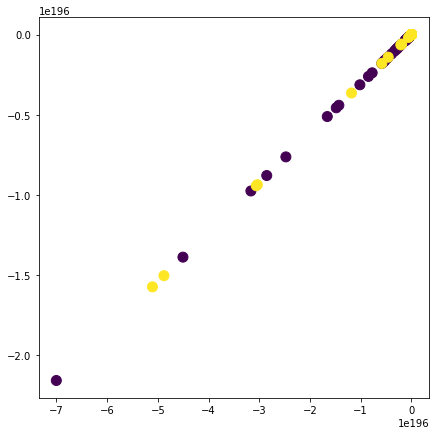

In [118]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.scatter(drawing[:, 0], drawing[:, 1], c=drawing[:, 2], s=100)
plt.show()